In [1]:
%pylab
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,tensorflow

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
CPython 3.5.4
IPython 6.2.1

numpy 1.14.0
pandas 0.22.0
tensorflow 1.5.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-31-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


필요한 패키지를 로드합니다.

In [2]:
import pandas as pd
import tensorflow as tf

In [3]:
import seaborn as sns

1000개의 데이터를 난수로 생성합니다. 대략 절반 정도는 평균:0.5, 표준편차:0.6의 x값과 평균:0.3, 표준편차:0.9의 y값을 가지고 나머지 절만 정도는 평균:2.5, 표준편차:0.4의 x값과 평균:0.8, 표준편차:0.5의 y값을 가집니다.

In [4]:
num_vectors = 1000
num_clusters = 4
num_steps = 100
vector_values = []
for i in range(num_vectors):
  if np.random.random() > 0.5:
    vector_values.append([np.random.normal(0.5, 0.6),
                          np.random.normal(0.3, 0.9)])
  else:
    vector_values.append([np.random.normal(2.5, 0.4),
                         np.random.normal(0.8, 0.5)])

vector_values 의 2차원 배열의 값을 각각 데이터프레임의 컬럼으로 지정합니다. 시본으로 그래프를 그립니다.

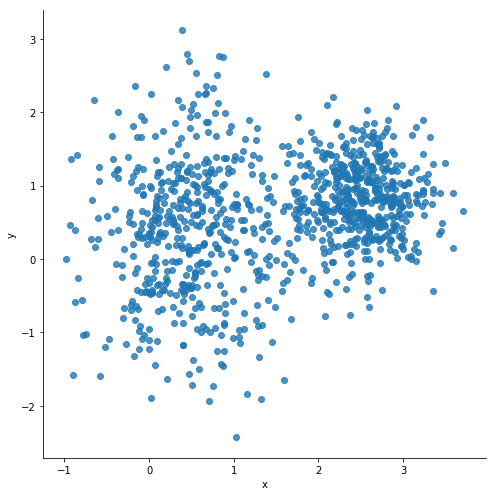

In [5]:
df = pd.DataFrame({"x": [v[0] for v in vector_values], 
                   "y": [v[1] for v in vector_values]})
sns.lmplot("x", "y", data=df, fit_reg=False, size=7)
plt.show()

vector_values를 사용하여 constant를 만들고 초기 센트로이드 네개를 랜덤하게 선택합니다. 그런 후에 vectors, centroids 텐서에 각각 차원을 추가합니다.

In [6]:
vectors = tf.constant(vector_values)
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [num_clusters,-1]))
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

print(expanded_vectors.get_shape())
print(expanded_centroids.get_shape())

(1, 1000, 2)
(4, 1, 2)


각 데이터 포인트에서 가장 가까운 센트로이드의 인덱스를 계산합니다.

In [7]:
distances = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)

각 클러스터의 평균 값을 계산하여 새로운 센트로이드를 구합니다.

In [8]:
means = tf.concat([
  tf.reduce_mean(
      tf.gather(vectors, 
                tf.reshape(
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1])
  for c in range(num_clusters)], 0)

update_centroids = tf.assign(centroids, means)

변수를 초기화하고 세션을 시작합니다.

In [9]:
init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

100번의 반복을 하여 센트로이드를 계산하고 결과를 출력합니다.

In [10]:
for step in range(num_steps):
   _, centroid_values, assignment_values = sess.run([update_centroids, centroids, assignments])

print("centroids")
print(centroid_values)

centroids
[[ 0.4124786  -0.521004  ]
 [ 2.3206093   0.36657366]
 [ 2.5714304   1.1806376 ]
 [ 0.43250743  1.0468391 ]]


vector_values 데이터를 클러스터에 따라 색깔을 구분하여 산포도를 그립니다.

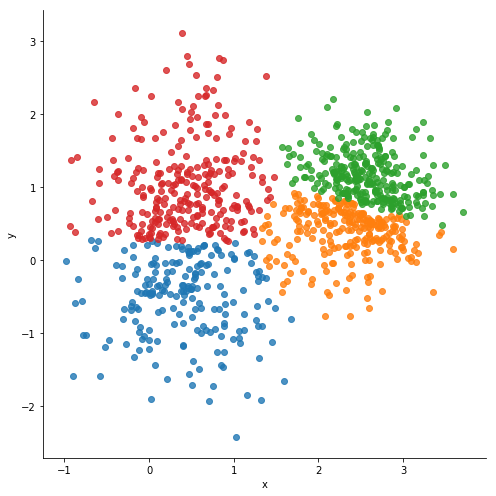

In [11]:
data = {"x": [], "y": [], "cluster": []}
for i in range(len(assignment_values)):
    data["x"].append(vector_values[i][0])
    data["y"].append(vector_values[i][1])
    data["cluster"].append(assignment_values[i])
df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, 
           fit_reg=False, size=7, 
           hue="cluster", legend=False)
plt.show()